In [1]:
import os
os.environ['HF_DATASETS_CACHE'] = 'D:/belajar/audio/vad/cache/huggingface'

# Then import and use datasets
from datasets import load_dataset

minds = load_dataset(
    "PolyAI/minds14", 
    name="en-AU", 
    split="train", 
    trust_remote_code=True,
    cache_dir='D:/belajar/audio/vad/cache/huggingface'
)

d:\belajar\audio\vad\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
example = minds[1]
example

{'path': 'D:\\belajar\\audio\\vad\\cache\\huggingface\\downloads\\extracted\\c94975066a712b12b6aa9618a7831b547edb98ecf2a3ab887f577af86078d02f\\en-AU~PAY_BILL\\response_17.wav',
 'audio': {'path': 'D:\\belajar\\audio\\vad\\cache\\huggingface\\downloads\\extracted\\c94975066a712b12b6aa9618a7831b547edb98ecf2a3ab887f577af86078d02f\\en-AU~PAY_BILL\\response_17.wav',
  'array': array([0.00024414, 0.        , 0.        , ..., 0.12487793, 0.10339355,
         0.03210449], shape=(63488,)),
  'sampling_rate': 8000},
 'transcription': 'hello I like to pay for Bill I would actually like to make a payment but yeah could you help me',
 'english_transcription': 'hello I like to pay for Bill I would actually like to make a payment but yeah could you help me',
 'intent_class': 13,
 'lang_id': 2}

In [3]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [4]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [5]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

d:\belajar\audio\vad\venv\Lib\site-packages\gradio\processing_utils.py:749: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


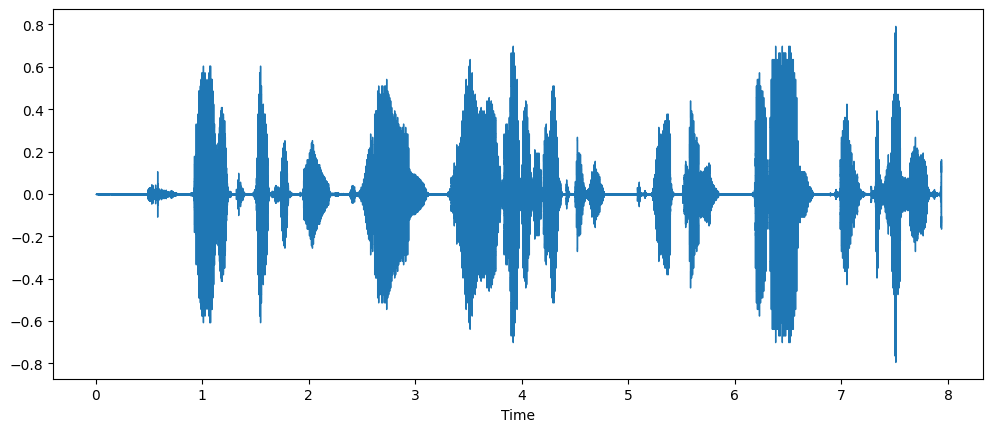

In [13]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [14]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds[0]

{'path': 'D:\\belajar\\audio\\vad\\cache\\huggingface\\downloads\\extracted\\c94975066a712b12b6aa9618a7831b547edb98ecf2a3ab887f577af86078d02f\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'D:\\belajar\\audio\\vad\\cache\\huggingface\\downloads\\extracted\\c94975066a712b12b6aa9618a7831b547edb98ecf2a3ab887f577af86078d02f\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04], shape=(124830,)),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [15]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [16]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter: 100%|██████████| 654/654 [00:00<00:00, 17738.80 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [17]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [18]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [19]:
minds = minds.map(prepare_dataset)
minds

Map: 100%|██████████| 624/624 [03:07<00:00,  3.32 examples/s] 


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

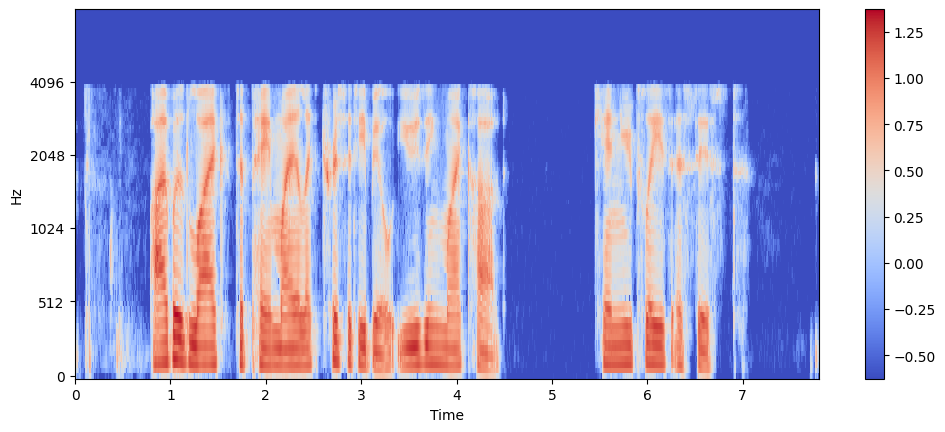

In [22]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()